## 20BCP085 - Aakash Bhandary - Assignment 6

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from feature_engine.selection import DropConstantFeatures, DropDuplicateFeatures, SmartCorrelatedSelection
from evalml.preprocessing import split_data
from evalml.automl import AutoMLSearch

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import warnings
warnings.simplefilter('ignore')

In [2]:
data = pd.read_csv(r"Assignment 6 - Diabetes\diabetes.csv")
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

In [5]:
x = data.drop('Outcome', axis=1)
y = data['Outcome']

In [6]:
# Normalising data
x = (x - x.mean()) / x.std()

In [7]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y)
xtrain.shape

(576, 8)

### Pipelining for feature selection 

In [8]:
pip = Pipeline([('constant', DropConstantFeatures(tol=0.9)), ('duplicate', DropDuplicateFeatures()), ('correlated', SmartCorrelatedSelection(threshold=0.9, estimator=SVC))])
new_xtrain = pip.fit_transform(xtrain)
new_xtrain.shape 
# No features Dropped

(576, 8)

In [9]:
sm=SMOTE()
xtrain_new, ytrain_new = sm.fit_resample(xtrain, ytrain)
ytrain_new.value_counts(), ytest.value_counts()

(1    377
 0    377
 Name: Outcome, dtype: int64,
 0    123
 1     69
 Name: Outcome, dtype: int64)

### Running Models 

#### 1) SVC 

In [10]:
model1 = SVC()
model1.fit(xtrain_new, ytrain_new)

SVC()

In [11]:
pred1 = model1.predict(xtest)
print(accuracy_score(ytest, pred1))

0.703125


#### 2) Random Forest Classifier 

In [12]:
model2 =  RandomForestClassifier()
model2.fit(xtrain_new, ytrain_new)

RandomForestClassifier()

In [13]:
pred2 = model2.predict(xtest)
print(accuracy_score(ytest, pred2))

0.7552083333333334


### AutoML  Data Splitting

In [14]:
xtrain, xtest, ytrain, ytest = split_data(x, y, problem_type='binary')
ytrain.value_counts(), xtrain.shape

(0    400
 1    214
 Name: Outcome, dtype: int64,
 (614, 8))

In [15]:
# SMOTE
sm=SMOTE()
xtrain_new, ytrain_new = sm.fit_resample(xtrain, ytrain)
ytrain_new.value_counts(), ytest.value_counts()

(1    400
 0    400
 Name: Outcome, dtype: int64,
 0    100
 1     54
 Name: Outcome, dtype: int64)

### AutoML Search 

In [16]:
auto = AutoMLSearch(xtrain_new, ytrain_new, problem_type='binary')
auto.search()
print(auto.best_pipeline)

	High coefficient of variation (cv >= 0.5) within cross validation scores.
	Decision Tree Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer + Select Columns Transformer may not perform as estimated on unseen data.


Random Forest Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer


In [17]:
auto.rankings

,id,pipeline_name,search_order,validation_score,mean_cv_score,standard_deviation_cv_score,percent_better_than_baseline,high_variance_cv,parameters
0,2,Random Forest Classifier w/ Label Encoder + Re...,2,0.476527,0.476527,0.026458,97.240649,False,"{'Label Encoder': {'positive_label': None}, 'I..."
1,4,Random Forest Classifier w/ Label Encoder + Re...,4,0.477323,0.477323,0.047555,97.236038,False,"{'Label Encoder': {'positive_label': None}, 'I..."
2,7,Extra Trees Classifier w/ Label Encoder + Repl...,7,0.506904,0.506904,0.021235,97.064749,False,"{'Label Encoder': {'positive_label': None}, 'I..."
3,1,Logistic Regression Classifier w/ Label Encode...,1,0.527056,0.527056,0.008616,96.948059,False,"{'Label Encoder': {'positive_label': None}, 'I..."
4,3,Logistic Regression Classifier w/ Label Encode...,3,0.533293,0.533293,0.001077,96.911939,False,"{'Label Encoder': {'positive_label': None}, 'I..."
5,8,Elastic Net Classifier w/ Label Encoder + Repl...,8,0.533305,0.533305,0.001129,96.911869,False,"{'Label Encoder': {'positive_label': None}, 'I..."
6,10,XGBoost Classifier w/ Label Encoder + Replace ...,10,0.571730,0.571730,0.105390,96.689370,False,"{'Label Encoder': {'positive_label': None}, 'I..."
7,6,LightGBM Classifier w/ Label Encoder + Replace...,6,0.603227,0.603227,0.136250,96.506984,False,"{'Label Encoder': {'positive_label': None}, 'I..."
8,9,CatBoost Classifier w/ Label Encoder + Replace...,9,0.641603,0.641603,0.002815,96.284767,False,"{'Label Encoder': {'positive_label': None}, 'I..."
9,5,Decision Tree Classifier w/ Label Encoder + Re...,5,3.656599,3.656599,0.462830,78.826286,True,"{'Label Encoder': {'positive_label': None}, 'I..."


In [18]:
auto.describe_pipeline(auto.rankings.iloc[0]["id"])


********************************************************************************************
* Random Forest Classifier w/ Label Encoder + Replace Nullable Types Transformer + Imputer *
********************************************************************************************

Problem Type: binary
Model Family: Random Forest

Pipeline Steps
1. Label Encoder
	 * positive_label : None
2. Replace Nullable Types Transformer
3. Imputer
	 * categorical_impute_strategy : most_frequent
	 * numeric_impute_strategy : mean
	 * boolean_impute_strategy : most_frequent
	 * categorical_fill_value : None
	 * numeric_fill_value : None
	 * boolean_fill_value : None
4. Random Forest Classifier
	 * n_estimators : 100
	 * max_depth : 6
	 * n_jobs : -1

Training
Training for binary problems.
Total training time (including CV): 0.9 seconds

Cross Validation
----------------
             Log Loss Binary  MCC Binary  Gini   AUC  Precision    F1  Balanced Accuracy Binary  Accuracy Binary # Training # Validat

In [19]:
best = auto.best_pipeline
best.score(xtest, ytest, objectives=['auc', 'precision', 'recall', 'f1'])

OrderedDict([('AUC', 0.8674074074074074),
             ('Precision', 0.6818181818181818),
             ('Recall', 0.8333333333333334),
             ('F1', 0.7499999999999999)])

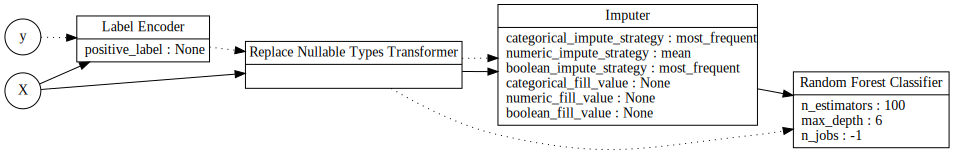

In [20]:
best.graph()

### Creating and Running the model  

In [21]:
model = best
model.fit(xtrain, ytrain)

pipeline = BinaryClassificationPipeline(component_graph={'Label Encoder': ['Label Encoder', 'X', 'y'], 'Replace Nullable Types Transformer': ['Replace Nullable Types Transformer', 'X', 'Label Encoder.y'], 'Imputer': ['Imputer', 'Replace Nullable Types Transformer.x', 'Replace Nullable Types Transformer.y'], 'Random Forest Classifier': ['Random Forest Classifier', 'Imputer.x', 'Replace Nullable Types Transformer.y']}, parameters={'Label Encoder':{'positive_label': None}, 'Imputer':{'categorical_impute_strategy': 'most_frequent', 'numeric_impute_strategy': 'mean', 'boolean_impute_strategy': 'most_frequent', 'categorical_fill_value': None, 'numeric_fill_value': None, 'boolean_fill_value': None}, 'Random Forest Classifier':{'n_estimators': 100, 'max_depth': 6, 'n_jobs': -1}}, random_seed=0)

In [22]:
pred = model.predict(xtest)

### Results 

In [23]:
print('Accuracy Score:', accuracy_score(ytest, pred))

Accuracy Score: 0.8051948051948052


<AxesSubplot:>

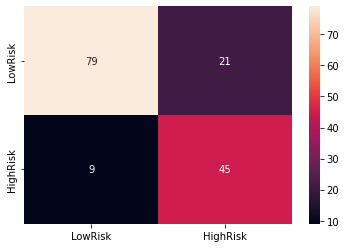

In [24]:
mat = confusion_matrix(ytest, pred)
sns.heatmap(mat, annot=True, fmt='d', xticklabels=['LowRisk', 'HighRisk'], yticklabels=['LowRisk', 'HighRisk'])

In [25]:
print(classification_report(ytest, pred))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84       100
           1       0.68      0.83      0.75        54

    accuracy                           0.81       154
   macro avg       0.79      0.81      0.80       154
weighted avg       0.82      0.81      0.81       154

